In [1]:
import pandas as pd
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
from datetime import timedelta
import requests

### 1. Collect data for the last 14 years - from 2010 to 2023 in daily granularity.
### 2. Identify top 10 outliers in each year.

In [2]:
def calculate_daily_returns(df, prev_close=None):
    if prev_close is not None:
        df.loc[df.index[0], 'prev_close'] = prev_close
    else:
        df['prev_close'] = df['c'].shift(1)
    df['daily_return'] = (df['c'] - df['prev_close']) / df['prev_close']
    df['abs_daily_return'] = df['daily_return'].abs()
    return df

def get_top_outliers(df, n=10):
    return df.nlargest(n, 'abs_daily_return')

# Define the API key and base URL
api_key = 'beBybSi8daPgsTp5yx5cHtHpYcrjp5Jq'

# Define the currency pairs and years
pair = "C:USDCHF"
years = range(2010, 2024)

# Initialize DataFrames
stats_data = pd.DataFrame(columns=['Year', 'Mean', 'Variance', 'Skewness', 'Kurtosis'])
full_data = pd.DataFrame()
outliers_data = pd.DataFrame()

# Loop over each year
for year in years:
	# Format the API endpoint
	start_date = f'{year}-01-01'
	end_date = f'{year}-12-31'
	url = f"https://api.polygon.io/v2/aggs/ticker/{pair}/range/1/day/{start_date}/{end_date}?adjusted=true&sort=asc&limit=50000&apiKey={api_key}"
	
	# Make the API request
	response = requests.get(url)
	data = response.json()
	
	# Check if the request was successful
	if response.status_code == 200 and 'results' in data:
		# Load data into a DataFrame
		df = pd.DataFrame(data['results'])
        # Converting timestamps
		df['date'] = pd.to_datetime(df['t'], unit='ms')
		df.drop(columns=['t'], inplace=True)
        # Calculating returns
		df = calculate_daily_returns(df)
        
		# Calculate basic statistical properties of the daily returns
		returns = df['daily_return'] 
		mean_return = returns.mean()
		variance_return = returns.var()
		skewness_return = skew(returns)
		kurtosis_return = kurtosis(returns)

		# Collect stats data by year
		year_stats = pd.DataFrame([[year, mean_return, variance_return, skewness_return, kurtosis_return]],
									columns=['Year', 'Mean', 'Variance', 'Skewness', 'Kurtosis'])
		stats_data = pd.concat([stats_data, year_stats], ignore_index=True)

		# Append the data to the full_data DataFrame for the current currency pair
		df['year'] = year
		full_data = pd.concat([full_data, df], ignore_index=True)

		# Find the top 10 outliers based on absolute values of the daily return value
		df['abs_daily_return'] = df['c'].abs()
		outliers = df.nlargest(10, 'abs_daily_return')

		# Append outliers to the outliers_data DataFrame for the current currency pair
		outliers['year'] = year
		outliers_data = pd.concat([outliers_data, outliers], ignore_index=True)

# Sort the data by date so that visualization could be done in a better way         
sorted_full_data = full_data.sort_values(by="date")
sorted_outliers_data = outliers_data.sort_values(by="date")

/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_57018/3047513548.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stats_data = pd.concat([stats_data, year_stats], ignore_index=True)


In [3]:
sorted_full_data

,v,vw,o,c,h,l,n,date,prev_close,daily_return,abs_daily_return,year
0,2359,1.0351,1.036260,1.036040,1.036880,1.033780,2359,2010-01-03,NaN,NaN,NaN,2010
1,69913,1.0329,1.036060,1.028910,1.041960,1.026210,69913,2010-01-04,1.03604,-0.006882,0.006882,2010
2,76822,1.0304,1.029000,1.033410,1.035960,1.025150,76822,2010-01-05,1.02891,0.004374,0.004374,2010
3,81057,1.0321,1.033410,1.027460,1.037830,1.024800,81057,2010-01-06,1.03341,-0.005758,0.005758,2010
4,72488,1.0321,1.027440,1.033700,1.037050,1.024140,72488,2010-01-07,1.02746,0.006073,0.006073,2010
...,...,...,...,...,...,...,...,...,...,...,...,...
4449,112192,0.8555,0.856000,0.853720,0.857960,0.852800,112192,2023-12-26,0.85581,-0.002442,0.002442,2023
4450,174820,0.8495,0.853590,0.842500,0.854870,0.840600,174820,2023-12-27,0.85372,-0.013142,0.013142,2023
4451,196178,0.8392,0.842400,0.843370,0.845145,0.833000,196178,2023-12-28,0.84250,0.001033,0.001033,2023
4452,214081,0.8403,0.843460,0.840710,0.843560,0.835400,214081,2023-12-29,0.84337,-0.003154,0.003154,2023


In [4]:
sorted_outliers_data

,v,vw,o,c,h,l,n,date,prev_close,daily_return,abs_daily_return,year
3,116306,1.1565,1.15104,1.16024,1.16191,1.14913,116306,2010-05-24,1.151030,0.008002,1.16024,2010
7,176660,1.1625,1.16023,1.15739,1.16950,1.15178,176660,2010-05-25,1.160240,-0.002456,1.15739,2010
5,135028,1.1579,1.15739,1.15873,1.16230,1.15139,135028,2010-05-26,1.157390,0.001158,1.15873,2010
4,103597,1.1541,1.15223,1.15927,1.15929,1.14801,103597,2010-05-28,1.152140,0.006188,1.15927,2010
6,4795,1.1580,1.15828,1.15740,1.15920,1.15709,4795,2010-05-30,1.159270,-0.001613,1.15740,2010
...,...,...,...,...,...,...,...,...,...,...,...,...
137,168297,0.9389,0.94201,0.93949,0.94290,0.93480,168297,2023-03-01,0.941868,-0.002524,0.93949,2023
132,164385,0.9419,0.93950,0.94180,0.94400,0.93890,164385,2023-03-02,0.939490,0.002459,0.94180,2023
138,2794,0.9366,0.93590,0.93680,0.93698,0.93550,2794,2023-03-05,0.935854,0.001011,0.93680,2023
130,172706,0.9356,0.93069,0.94223,0.94260,0.92830,172706,2023-03-07,0.930550,0.012552,0.94223,2023


In [5]:
stats_data

,Year,Mean,Variance,Skewness,Kurtosis
0,2010,-0.000314,0.000038,NaN,NaN
1,2011,0.000070,0.000097,NaN,NaN
2,2012,-0.000074,0.000024,NaN,NaN
3,2013,-0.000060,0.000028,NaN,NaN
4,2014,0.000349,0.000015,NaN,NaN
5,2015,0.000075,0.000128,NaN,NaN
6,2016,0.000067,0.000020,NaN,NaN
7,2017,-0.000133,0.000015,NaN,NaN
8,2018,0.000036,0.000013,NaN,NaN
9,2019,-0.000068,0.000010,NaN,NaN


Skewness and Kurtosis (NaN): The NaN values likely indicate that daily returns for many years are very close to zero with little variance, thus not allowing for a meaningful calculation of skewness and kurtosis. This could mean the market is highly stable on a day-to-day basis, with changes being very subtle.

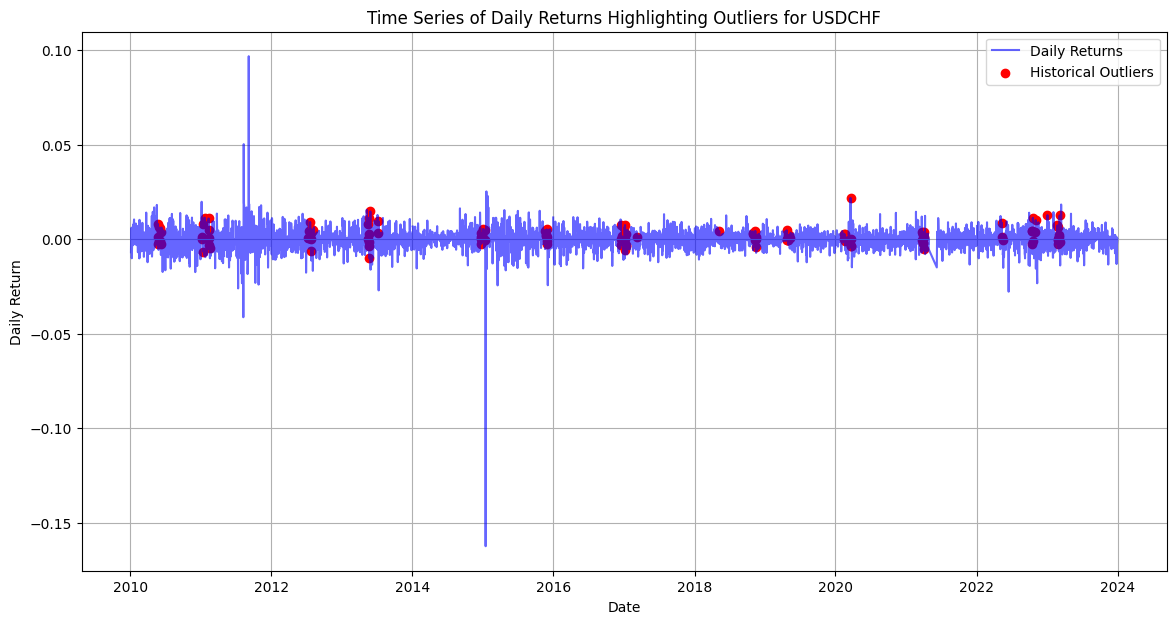

In [6]:
def plot_data_with_outliers(full_data, outliers_data):
    plt.figure(figsize=(14, 7))
    plt.plot(full_data['date'], full_data['daily_return'], label='Daily Returns', color='blue', alpha=0.6)
    plt.scatter(outliers_data['date'], outliers_data['daily_return'], color='red', label='Historical Outliers')
    plt.xlabel('Date')
    plt.ylabel('Daily Return')
    plt.title('Time Series of Daily Returns Highlighting Outliers for USDCHF')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot data with outliers
plot_data_with_outliers(sorted_full_data, outliers_data)

### 3. Collect data of 3 days prior and post for each of these outliers in hourly granularity.

In [7]:
# Convert dates in dataset to datetime objects
sorted_outliers_data['date'] = pd.to_datetime(sorted_outliers_data['date'])

date_ranges = pd.DataFrame({
    "start_date": sorted_outliers_data['date'] - timedelta(days=3),
    "end_date": sorted_outliers_data['date'] + timedelta(days=3),
    "outlier_date": sorted_outliers_data['date'],
    "year": sorted_outliers_data['year']
})

date_ranges

,start_date,end_date,outlier_date,year
3,2010-05-21,2010-05-27,2010-05-24,2010
7,2010-05-22,2010-05-28,2010-05-25,2010
5,2010-05-23,2010-05-29,2010-05-26,2010
4,2010-05-25,2010-05-31,2010-05-28,2010
6,2010-05-27,2010-06-02,2010-05-30,2010
...,...,...,...,...
137,2023-02-26,2023-03-04,2023-03-01,2023
132,2023-02-27,2023-03-05,2023-03-02,2023
138,2023-03-02,2023-03-08,2023-03-05,2023
130,2023-03-04,2023-03-10,2023-03-07,2023


In [8]:
def calculate_daily_returns(df, prev_close=None):
    if prev_close is not None:
        df.loc[df.index[0], 'prev_close'] = prev_close
    else:
        df['prev_close'] = df['c'].shift(1)
    df['returns'] = (df['c'] - df['prev_close']) / df['prev_close']
    return df

def fetch_and_process_hourly_data(symbol, start_date, end_date, api_key):
    # Format the dates as strings for URL
    formatted_start_date = start_date.strftime('%Y-%m-%d')
    formatted_end_date = end_date.strftime('%Y-%m-%d')

    url = f"https://api.polygon.io/v2/aggs/ticker/{symbol}/range/1/hour/{formatted_start_date}/{formatted_end_date}?apiKey={api_key}"
    response = requests.get(url)
    response_data = response.json()

    if response.status_code != 200 or 'results' not in response_data:
        print(f"Failed to fetch data or 'results' not in response: {response.status_code} - {response.text}")
        return None

    df = pd.DataFrame(response_data['results'])
    df['date'] = pd.to_datetime(df['t'], unit='ms')
    df.drop(columns=['t'], inplace=True)

    hourly_data = calculate_daily_returns(df)
    hourly_data.set_index('date', inplace=True)

    # Create full index from start_date to end_date at hourly frequency
    full_index = pd.date_range(start=start_date, end=end_date + timedelta(days=1), freq='H')

    # Reindex hourly_data using the full index, filling missing rows with NaN
    hourly_data = hourly_data.reindex(full_index)

    hourly_data.reset_index(inplace=True)
    hourly_data.rename(columns={'index': 'date'}, inplace=True)

    return hourly_data

In [9]:
# Initialize empty DataFrame
all_data = pd.DataFrame()

# Initialize an outlier identifier starting from 1 or any specific number
outlier_id = 1

for index, row in date_ranges.iterrows():
    # Convert start_date, end_date, and outlier_date to Timestamp for consistent comparison
    start_date_ts = pd.Timestamp(row['start_date'])
    end_date_ts = pd.Timestamp(row['end_date']) + pd.Timedelta(days=1)  # Extend the end date by one additional day
    outlier_date_ts = pd.Timestamp(row['outlier_date'])

    # Get hourly data for the range including 3 days before and after the outlier
    hourly_data = fetch_and_process_hourly_data(pair, start_date_ts, end_date_ts, api_key)

    # Check if hourly_data is not None before processing
    if hourly_data is not None:
        # Assign the current outlier_id to the data
        hourly_data['outlier_id'] = outlier_id

        # prior_data from start_date to outlier_date inclusive
        prior_data = hourly_data[(hourly_data['date'] >= start_date_ts) & (hourly_data['date'] < outlier_date_ts)]
        prior_data["day type"] = "prior day"

        # outlier_data is for the hourly data on the day of the outlier
        outlier_data = hourly_data[(hourly_data['date'].dt.date == outlier_date_ts.date())]
        outlier_data["day type"] = "outlier day"

        # post_data from the day after outlier_date to end_date
        post_outlier_ts = outlier_date_ts + pd.Timedelta(days=1)  # Starting the day after the outlier_date
        post_data = hourly_data[(hourly_data['date'] >= post_outlier_ts) & (hourly_data['date'] <= end_date_ts)]
        post_data["day type"] = "post day"

        # Concatenate the data from this iteration to the cumulative DataFrame
        all_data = pd.concat([all_data, prior_data, outlier_data, post_data])

        # Increment the outlier_id for the next iteration
        outlier_id += 1

    else:
        print(f"Data not available for symbol {pair} from {row['start_date'].date()} to {row['end_date'].date()}")

# Optionally, you can reset the index of the final DataFrame if it becomes non-unique after concatenations
all_data.reset_index(drop=True, inplace=True)

/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_57018/4033729921.py:30: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_index = pd.date_range(start=start_date, end=end_date + timedelta(days=1), freq='H')
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_57018/2856259322.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_57018/2856259322.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

In [10]:
all_data

,date,v,vw,o,c,h,l,n,prev_close,returns,outlier_id,day type
0,2010-05-21 00:00:00,7789.0,1.1496,1.14874,1.14920,1.15096,1.14803,7789.0,NaN,NaN,1,prior day
1,2010-05-21 01:00:00,5850.0,1.1500,1.14920,1.15099,1.15252,1.14815,5850.0,1.14920,0.001558,1,prior day
2,2010-05-21 02:00:00,6241.0,1.1526,1.15103,1.15387,1.15737,1.15017,6241.0,1.15099,0.002502,1,prior day
3,2010-05-21 03:00:00,4263.0,1.1550,1.15392,1.15403,1.15797,1.15303,4263.0,1.15387,0.000139,1,prior day
4,2010-05-21 04:00:00,7278.0,1.1522,1.15399,1.15319,1.15433,1.14992,7278.0,1.15403,-0.000728,1,prior day
...,...,...,...,...,...,...,...,...,...,...,...,...
23655,2023-03-11 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140,post day
23656,2023-03-11 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140,post day
23657,2023-03-11 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140,post day
23658,2023-03-11 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140,post day


In [11]:
# Reset the index to have simple numbers and separate "date" and "time" columns
all_data.reset_index(inplace=True)
all_data.rename(columns={'index': 'New'}, inplace=True)

# Convert date to string format if necessary
all_data['date'] = all_data['date'].astype(str)

# Extract date and time from the date string
all_data['Date'] = all_data['date'].str[:10]
all_data['Time'] = all_data['date'].str[11:19]

# Drop the 'date' column if it's no longer needed
all_data.drop(columns=['date', 'New', 'v'], inplace=True)

In [12]:
all_data.to_csv("USDCHF_hourly_new.csv")